# Geovisualisation

## 📖 Ahead of time...

This block is all about visualising statistical data on top of a geography. Although this task looks simple, there are a few technical and conceptual building blocks that it helps to understand before we try to make our own maps. Aim to complete the following readings by the time we get our hands on the keyboard: 

- [Block D](https://darribas.org/gds_course/content/bD/concepts_D.html) of the GDS course {cite}`darribas_gds_course`, which provides an introduction to choropleths (statistical maps)
- [Chapter 5](https://geographicdata.science/book/notebooks/05_choropleth.html) of the GDS Book {cite}`reyABwolf`, discussing choropleths in more detail


## 💻 Hands-on coding

In [1]:
import geopandas
import xarray, rioxarray
import contextily
import seaborn as sns
from pysal.viz import mapclassify as mc
from legendgram import legendgram
import matplotlib.pyplot as plt
import palettable.matplotlib as palmpl

````{tabbed} Local files

Assuming you have the file locally on the path `../data/`: 

```python
db = geopandas.read_file("../data/cambodia_regional.gpkg")
```
````

````{tabbed} Online read

If you're online, you can do:

```python
db = geopandas.read_file(
    "https://darribas.org/gds4ae/_downloads/9366d230310a8a68b2ce6cf2787a2f1c/cambodia_regional.gpkg"
)
```
````

```{margin} Data
If you want to read more about the data sources behind this dataset, head to the [Datasets](../data/datasets) section
```


In [2]:
db = geopandas.read_file("../data/cambodia_regional.gpkg")

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


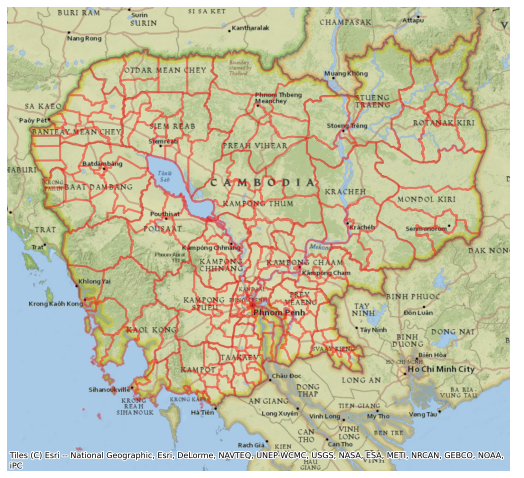

In [3]:
ax = db.to_crs(
    epsg=3857
).plot(
    edgecolor="red",
    facecolor="none",
    linewidth=2,
    alpha=0.25,
    figsize=(9, 9)
)
contextily.add_basemap(
    ax,
    source=contextily.providers.Esri.NatGeoWorldMap
)
ax.set_axis_off();

In [4]:
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   adm2_name   198 non-null    object  
 1   adm2_altnm  122 non-null    object  
 2   motor_mean  198 non-null    float64 
 3   walk_mean   198 non-null    float64 
 4   no2_mean    198 non-null    float64 
 5   geometry    198 non-null    geometry
dtypes: float64(3), geometry(1), object(2)
memory usage: 9.4+ KB


We will use the average measurement of [nitrogen dioxide](http://www.tropomi.eu/data-products/nitrogen-dioxide) (`no2_mean`) by region throughout the block. 

To make visualisation a bit easier below, we create an additional column with values rescaled:

In [5]:
db["no2_viz"] = db["no2_mean"] * 1e5

This way, numbers are larger and will fit more easily on legends:

In [6]:
db[["no2_mean", "no2_viz"]].describe()

,no2_mean,no2_viz
count,198.000000,198.000000
mean,0.000032,3.236567
std,0.000017,1.743538
min,0.000014,1.377641
25%,0.000024,2.427438
50%,0.000029,2.922031
75%,0.000034,3.390426
max,0.000123,12.323324


### Choropleths

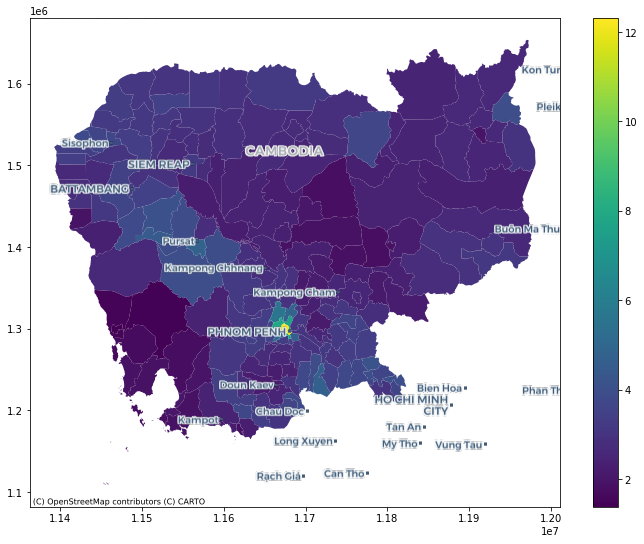

In [7]:
ax = db.to_crs(
    epsg=3857
).plot(
    "no2_viz", 
    legend=True,
    figsize=(12, 9)
)
contextily.add_basemap(
    ax, 
    source=contextily.providers.CartoDB.VoyagerOnlyLabels,
    zoom=7
);

#### A classiffication problem

In [8]:
db["no2_viz"].unique().shape

(198,)

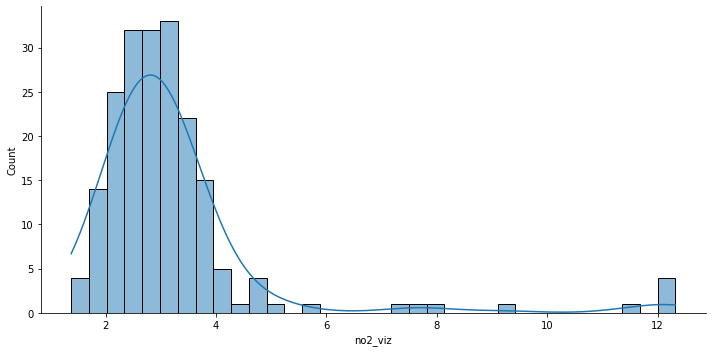

In [9]:
sns.displot(
    db, x="no2_viz", kde=True, aspect=2
);

```{attention}
To build an intuition behind each classification algorithm more easily, we create a helper method (`plot_classi`) that generates a visualisation of a given classification.

Toggle the cell below if you are interested in the code behind it.
```

In [10]:
def plot_classi(classi, col, db):
    """
    Illustrate a classiffication
    ...
    
    Arguments
    ---------
    classi : mapclassify.classifiers
             Classification object
    col    : str
             Column name used for `classi`
    db     : geopandas.GeoDataFrame
             Geo-table with data for
             the classification    
    """
    f, ax = plt.subplots(figsize=(12, 6))
    ax.set_title(classi.name)
    # KDE
    sns.kdeplot(
        db[col], fill=True, ax=ax
    )
    for i in range(0, len(classi.bins)-1):
        ax.axvline(classi.bins[i], color="red")
    # Map
    aux = f.add_axes([.6, .45, .32, .4])
    db.assign(lbls=classi.yb).plot(
        "lbls", cmap="viridis", ax=aux
    )
    aux.set_axis_off()
    return None

- Equal intervals

In [11]:
classi = mc.EqualInterval(db["no2_viz"], k=7)
classi

EqualInterval         

   Interval      Count
----------------------
[ 1.38,  2.94] |   103
( 2.94,  4.50] |    80
( 4.50,  6.07] |     6
( 6.07,  7.63] |     1
( 7.63,  9.20] |     3
( 9.20, 10.76] |     0
(10.76, 12.32] |     5

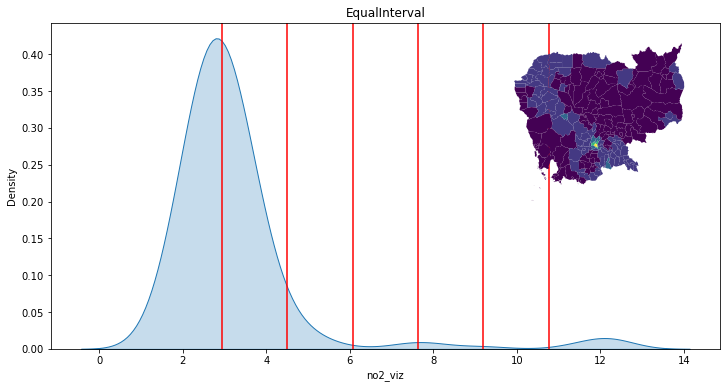

In [12]:
plot_classi(classi, "no2_viz", db)

- Quantiles

In [13]:
classi = mc.Quantiles(db["no2_viz"], k=7)
classi

Quantiles             

   Interval      Count
----------------------
[ 1.38,  2.24] |    29
( 2.24,  2.50] |    28
( 2.50,  2.76] |    28
( 2.76,  3.02] |    28
( 3.02,  3.35] |    28
( 3.35,  3.76] |    28
( 3.76, 12.32] |    29

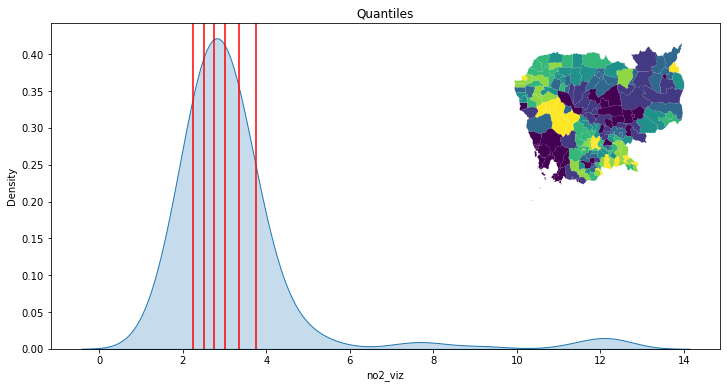

In [14]:
plot_classi(classi, "no2_viz", db)

- Fisher-Jenks

In [15]:
classi = mc.FisherJenks(db["no2_viz"], k=7)
classi

FisherJenks           

   Interval      Count
----------------------
[ 1.38,  2.06] |    20
( 2.06,  2.69] |    58
( 2.69,  3.30] |    62
( 3.30,  4.19] |    42
( 4.19,  5.64] |     7
( 5.64,  9.19] |     4
( 9.19, 12.32] |     5

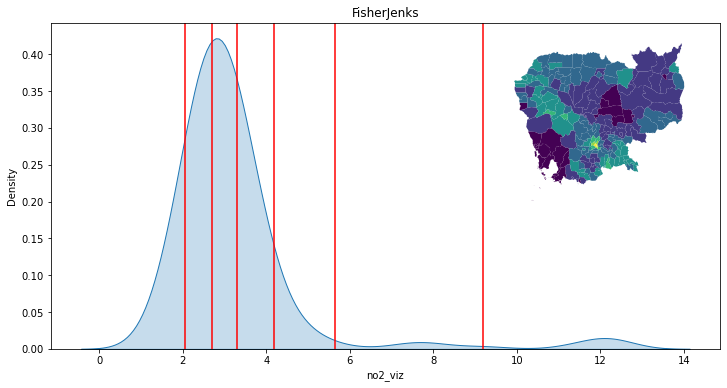

In [16]:
plot_classi(classi, "no2_viz", db)

- Fisher-Jenks

In [17]:
classi = mc.FisherJenks(db["no2_viz"], k=7)
classi

FisherJenks           

   Interval      Count
----------------------
[ 1.38,  2.06] |    20
( 2.06,  2.69] |    58
( 2.69,  3.30] |    62
( 3.30,  4.19] |    42
( 4.19,  5.64] |     7
( 5.64,  9.19] |     4
( 9.19, 12.32] |     5

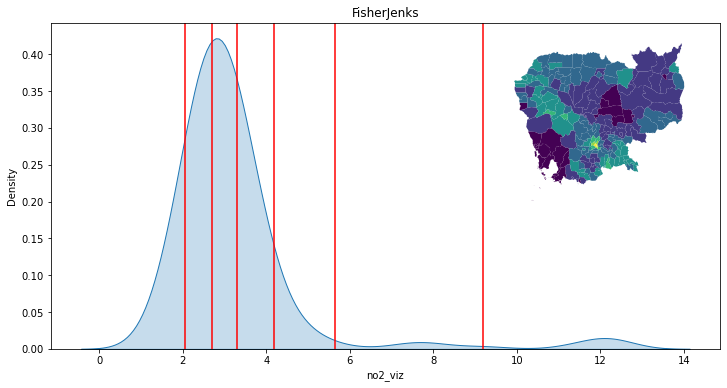

In [18]:
plot_classi(classi, "no2_viz", db)

---

Now let's dig into the internals of `classi`:

In [19]:
classi

FisherJenks           

   Interval      Count
----------------------
[ 1.38,  2.06] |    20
( 2.06,  2.69] |    58
( 2.69,  3.30] |    62
( 3.30,  4.19] |    42
( 4.19,  5.64] |     7
( 5.64,  9.19] |     4
( 9.19, 12.32] |     5

In [20]:
classi.k

7

In [21]:
classi.bins

array([ 2.05617382,  2.6925931 ,  3.30281182,  4.19124954,  5.63804861,
        9.19190206, 12.32332434])

In [22]:
classi.yb

array([2, 3, 3, 1, 1, 2, 1, 1, 1, 0, 0, 3, 2, 1, 1, 1, 3, 1, 1, 1, 2, 0,
       0, 4, 2, 1, 3, 1, 0, 0, 0, 1, 2, 2, 6, 5, 4, 2, 1, 3, 2, 3, 2, 1,
       2, 3, 2, 3, 1, 1, 3, 1, 2, 3, 3, 1, 3, 3, 1, 0, 1, 1, 3, 2, 0, 0,
       2, 1, 0, 0, 0, 2, 0, 1, 3, 3, 3, 2, 3, 2, 3, 1, 2, 3, 1, 1, 1, 1,
       2, 1, 2, 2, 1, 2, 2, 2, 1, 3, 2, 3, 2, 2, 2, 1, 2, 3, 3, 2, 0, 3,
       1, 0, 1, 2, 1, 1, 2, 1, 2, 6, 5, 6, 2, 2, 3, 6, 3, 4, 3, 4, 2, 3,
       0, 2, 5, 6, 4, 5, 2, 2, 2, 1, 1, 1, 2, 1, 2, 3, 3, 2, 2, 2, 3, 2,
       1, 1, 3, 4, 2, 1, 3, 1, 2, 3, 4, 0, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2,
       2, 2, 0, 0, 1, 2, 3, 3, 3, 3, 3, 2, 1, 2, 1, 1, 1, 2, 2, 1, 3, 1])

#### How *many* colors?

````{margin}
```{attention}
The code used to generate this figure uses more advanced features than planned for this course.

If you want to inspect it, toggle the cell below.
```
````

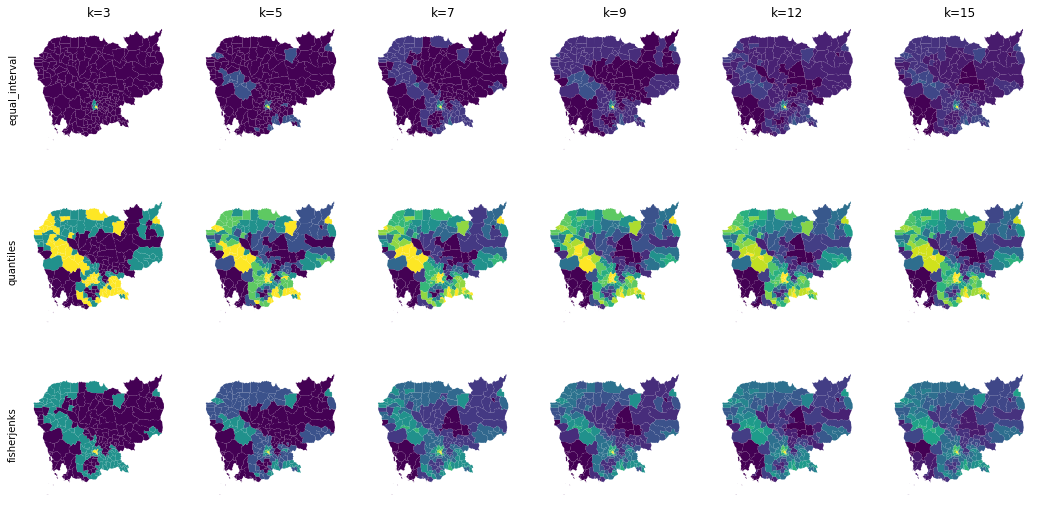

In [23]:
vals = [3, 5, 7, 9, 12, 15]
algos = ["equal_interval", "quantiles", "fisherjenks"]
f, axs = plt.subplots(
    len(algos), len(vals), figsize=(3*len(vals), 3*len(algos))
)
for i in range(len(algos)):
    for j in range(len(vals)):
        db.plot(
            "no2_viz", scheme=algos[i], k=vals[j], ax=axs[i, j]
        )
        axs[i, j].set_axis_off()
        if i==0:
            axs[i, j].set_title(f"k={vals[j]}")
        if j==0:
            axs[i, j].text(
                -0.1, 
                0.5, 
                algos[i], 
                horizontalalignment='center',
                verticalalignment='center', 
                transform=axs[i, j].transAxes,
                rotation=90
            )

#### Using the *right* color

```{margin}
For a safe choice, make sure to visit [ColorBrewer](https://colorbrewer2.org/)
```

* [<img src="../figs/l04_pal_qual.png" alt="Qualitative"
style="width:300px;height:50px;vertical-align:middle;border:0px;" class="fragment"/>](https://jiffyclub.github.io/palettable/wesanderson/#fantasticfox2_5) **Categories**, non-ordered
* [<img src="../figs/l04_pal_seq.png" alt="Sequential"
style="width:300px;height:50px;vertical-align:middle;border:0px;" class="fragment"/>](https://jiffyclub.github.io/palettable/colorbrewer/sequential/#rdpu_5) Graduated, **sequential**
* [<img src="../figs/l04_pal_div.png" alt="Divergent"
style="width:300px;height:50px;vertical-align:middle;border:0px;" class="fragment"/>](https://jiffyclub.github.io/palettable/colorbrewer/diverging/#rdylgn_5) Graduated, **divergent**

### Choropleths on Geo-Tables

How can we create classifications from data on geo-tables? Two ways:

- Directly within `plot` (only for some algorithms)

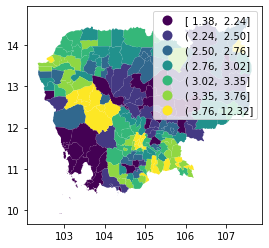

In [24]:
db.plot(
    "no2_viz", scheme="quantiles", k=7, legend=True
);

```{margin}
See [this tutorial](https://pysal.org/mapclassify/notebooks/03_choropleth.html) for more details on fine tuning choropleths manually
```

- Manually attaching the data (for any algorithm)

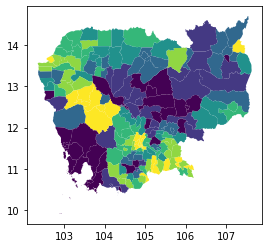

In [25]:
classi = mc.Quantiles(db["no2_viz"], k=7)
db.assign(
    classes=classi.yb
).plot("classes");

---

*Legendgrams*:

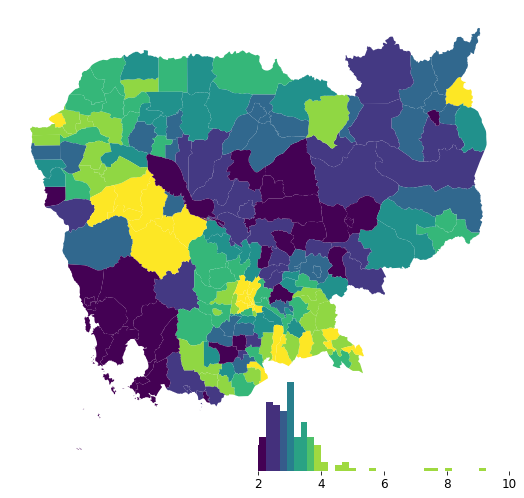

In [26]:
f, ax = plt.subplots(figsize=(9, 9))

classi = mc.Quantiles(db["no2_viz"], k=7)

db.assign(
    classes=classi.yb
).plot("classes", ax=ax)

legendgram(
    f,                   # Figure object
    ax,                  # Axis object of the map
    db["no2_viz"],       # Values for the histogram
    classi.bins,         # Bin boundaries
    pal=palmpl.Viridis_7,# color palette (as palettable object)
    legend_size=(.5,.2), # legend size in fractions of the axis
    loc = 'lower right', # matplotlib-style legend locations
    clip = (2,10)        # clip the displayed range of the histogram
)
ax.set_axis_off();

### Surface visualisation

```{margin} Data
If you want to read more about the data sources behind this dataset, head to the [Datasets](../data/datasets) section
```


````{tabbed} Local files

Assuming you have the file locally on the path `../data/`: 

```python
grid = xarray.open_rasterio(
    "../data/cambodia_s5_no2.tif"
).sel(band=1)
```
````

````{tabbed} Online read

If you're online, you can do:

```python
grid = xarray.open_rasterio(
    "https://darribas.org/gds4ae/_downloads/0d14506cd792aecf73dd0f7f027e95b4/cambodia_s5_no2.tif"
).sel(band=1)
```
````


In [27]:
grid = xarray.open_rasterio("../data/cambodia_s5_no2.tif").sel(band=1)

- (Implicit) continuous equal interval

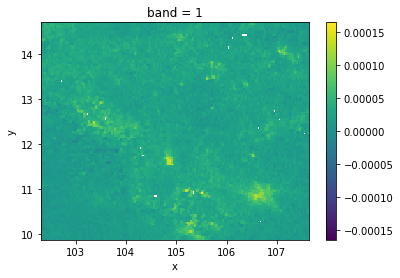

In [28]:
grid.where(
    grid != grid.rio.nodata
).plot(cmap="viridis");

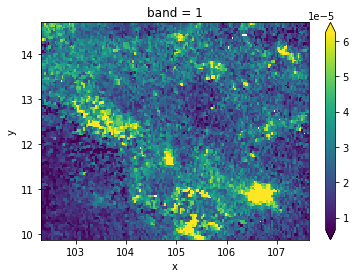

In [29]:
grid.where(
    grid != grid.rio.nodata
).plot(cmap="viridis", robust=True);

- Discrete equal interval

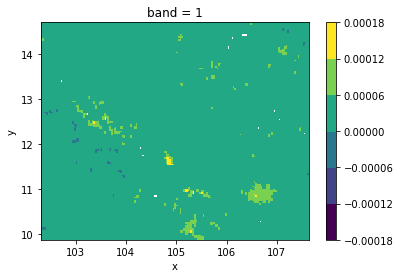

In [30]:
grid.where(
    grid != grid.rio.nodata
).plot(cmap="viridis", levels=7)

- Combining with `mapclassify`

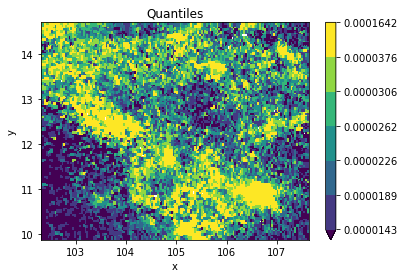

In [31]:
grid_nona = grid.where(
    grid != grid.rio.nodata
)

classi = mc.Quantiles(
    grid_nona.to_series().dropna(), k=7
)

grid_nona.plot(
    cmap="viridis", levels=classi.bins
)
plt.title(classi.name);

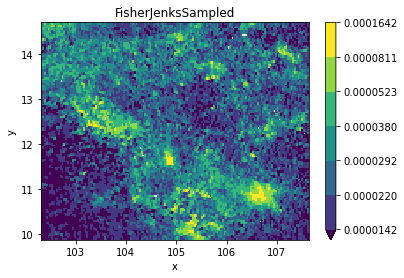

In [32]:
grid_nona = grid.where(
    grid != grid.rio.nodata
)

classi = mc.FisherJenksSampled(
    grid_nona.to_series().dropna().values, k=7
)

grid_nona.plot(
    cmap="viridis", levels=classi.bins
)
plt.title(classi.name);

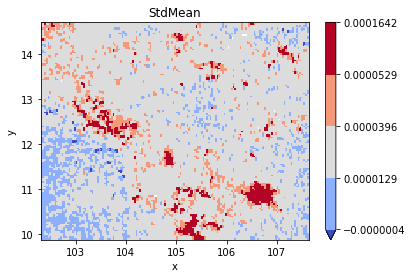

In [33]:
grid_nona = grid.where(
    grid != grid.rio.nodata
)

classi = mc.StdMean(
    grid_nona.to_series().dropna().values
)

grid_nona.plot(
    cmap="coolwarm", levels=classi.bins
)
plt.title(classi.name);

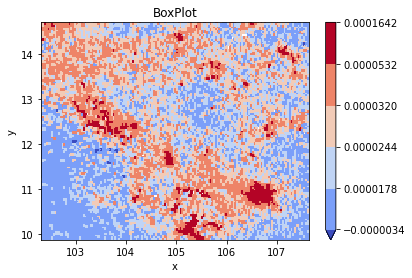

In [34]:
grid_nona = grid.where(
    grid != grid.rio.nodata
)

classi = mc.BoxPlot(
    grid_nona.to_series().dropna().values
)

grid_nona.plot(
    cmap="coolwarm", levels=classi.bins
)
plt.title(classi.name);

## 🐾 Next steps

If you are interested in statistical maps based on classification, here are two recommendations to check out next:

- On the technical side, the [documentation for `mapclassify`](https://pysal.org/mapclassify/) (including its [tutorials](https://pysal.org/mapclassify/tutorial.html)) provides more detail and illustrates more classification algorithms than those reviewed in this block
- On a more conceptual note, Cynthia Brewer's "Designing better maps" {cite}`brewer2015designing` is an excellent blueprint for good map making.